In [1]:
import calendar 
from datetime import datetime
import dask.dataframe as dd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn')
sns.set_style('whitegrid')

In [2]:
# load crimes parquet data into dask df
data_file_name = '../data/crimes-2017-7-4.parq'
crimes = dd.read_parquet(data_file_name, index='Date')

In [3]:
%%time
# log records count and load data partitions
print("{:,} total records in {} partitions".format(len(crimes), crimes.npartitions))
print("DataFrame size: {:,}".format(crimes.size.compute()))

129,956 total records in 1 partitions
DataFrame size: 1,039,648
Wall time: 2.64 s


In [4]:
# check data frame structure
crimes

,Block,PrimaryType,Description,LocationDescription,Arrest,Domestic,Latitude,Longitude
npartitions=1,,,,,,,,
2017-01-01 00:00:00,object,object,object,object,bool,bool,float64,float64
2017-07-04 23:50:00,...,...,...,...,...,...,...,...


In [5]:
# preview crimes data with Date index
crimes.head()

,Block,PrimaryType,Description,LocationDescription,Arrest,Domestic,Latitude,Longitude
Date,,,,,,,,
2017-07-04 18:39:00,002XX E 132ND ST,HOMICIDE,FIRST DEGREE MURDER,AUTO,False,False,41.655619,-87.616339
2017-04-11 14:00:00,038XX N LINCOLN AVE,THEFT,OVER $500,RESTAURANT,False,False,NaN,NaN
2017-05-20 14:00:00,008XX N HAMLIN AVE,OTHER OFFENSE,TELEPHONE THREAT,APARTMENT,False,False,NaN,NaN
2017-07-04 08:00:00,043XX N CICERO AVE,DECEPTIVE PRACTICE,"THEFT BY LESSEE,MOTOR VEH",OTHER,False,False,NaN,NaN
2017-07-04 07:14:00,014XX W 79TH ST,CRIMINAL DAMAGE,TO PROPERTY,STREET,False,False,NaN,NaN


In [6]:
# get crime types
crime_types = crimes[['PrimaryType']]

In [7]:
crime_types.head()

,PrimaryType
Date,
2017-07-04 18:39:00,HOMICIDE
2017-04-11 14:00:00,THEFT
2017-05-20 14:00:00,OTHER OFFENSE
2017-07-04 08:00:00,DECEPTIVE PRACTICE
2017-07-04 07:14:00,CRIMINAL DAMAGE


In [8]:
# get crime counts by primary type
crime_type_total = crime_types.groupby('PrimaryType').size().compute()
print(crime_type_total)

PrimaryType
ARSON                                  233
ASSAULT                               9695
BATTERY                              24708
BURGLARY                              6361
CONCEALED CARRY LICENSE VIOLATION       29
CRIM SEXUAL ASSAULT                    716
CRIMINAL DAMAGE                      14525
CRIMINAL TRESPASS                     3518
DECEPTIVE PRACTICE                    8360
GAMBLING                                90
HOMICIDE                               329
HUMAN TRAFFICKING                        5
INTERFERENCE WITH PUBLIC OFFICER       568
INTIMIDATION                            71
KIDNAPPING                              93
LIQUOR LAW VIOLATION                   109
MOTOR VEHICLE THEFT                   5669
NARCOTICS                             5198
NON-CRIMINAL                            18
NON-CRIMINAL (SUBJECT SPECIFIED)         2
OBSCENITY                               33
OFFENSE INVOLVING CHILDREN            1085
OTHER NARCOTIC VIOLATION                 1

In [9]:
# get arrests and domestic counts for each primary crime type
crime_type_counts = crimes[['PrimaryType', 'Arrest', 'Domestic']].groupby('PrimaryType').sum().compute()
print(crime_type_counts)

                                   Arrest  Domestic
PrimaryType                                        
ARSON                                14.0       8.0
ASSAULT                            1700.0    2493.0
BATTERY                            4945.0   12020.0
BURGLARY                            219.0      86.0
CONCEALED CARRY LICENSE VIOLATION    28.0       0.0
CRIM SEXUAL ASSAULT                  24.0     108.0
CRIMINAL DAMAGE                     857.0    1682.0
CRIMINAL TRESPASS                  2163.0     161.0
DECEPTIVE PRACTICE                  307.0      77.0
GAMBLING                             90.0       0.0
HOMICIDE                             47.0      16.0
HUMAN TRAFFICKING                     0.0       2.0
INTERFERENCE WITH PUBLIC OFFICER    538.0       3.0
INTIMIDATION                          4.0       6.0
KIDNAPPING                            8.0      31.0
LIQUOR LAW VIOLATION                109.0       1.0
MOTOR VEHICLE THEFT                 461.0      51.0
NARCOTICS   

In [10]:
# add crime type totals column
crime_type_counts['Total'] = crime_type_total

In [11]:
print(crime_type_counts)

                                   Arrest  Domestic  Total
PrimaryType                                               
ARSON                                14.0       8.0    233
ASSAULT                            1700.0    2493.0   9695
BATTERY                            4945.0   12020.0  24708
BURGLARY                            219.0      86.0   6361
CONCEALED CARRY LICENSE VIOLATION    28.0       0.0     29
CRIM SEXUAL ASSAULT                  24.0     108.0    716
CRIMINAL DAMAGE                     857.0    1682.0  14525
CRIMINAL TRESPASS                  2163.0     161.0   3518
DECEPTIVE PRACTICE                  307.0      77.0   8360
GAMBLING                             90.0       0.0     90
HOMICIDE                             47.0      16.0    329
HUMAN TRAFFICKING                     0.0       2.0      5
INTERFERENCE WITH PUBLIC OFFICER    538.0       3.0    568
INTIMIDATION                          4.0       6.0     71
KIDNAPPING                            8.0      31.0     

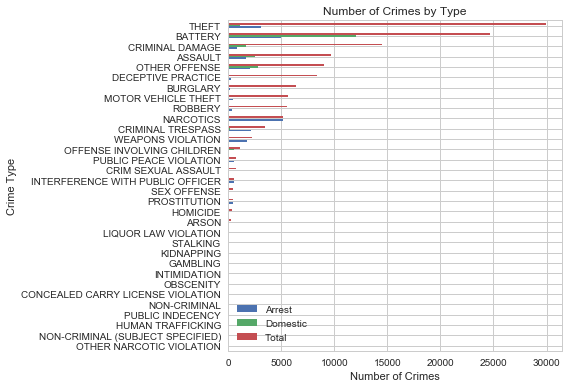

In [12]:
# plot crimes by primary type total ascending
plt.figure(figsize=(8,10))
crime_type_counts.sort_values(by='Total', ascending=True).plot(kind='barh')
plt.title('Number of Crimes by Type')
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.tight_layout()
plt.show()

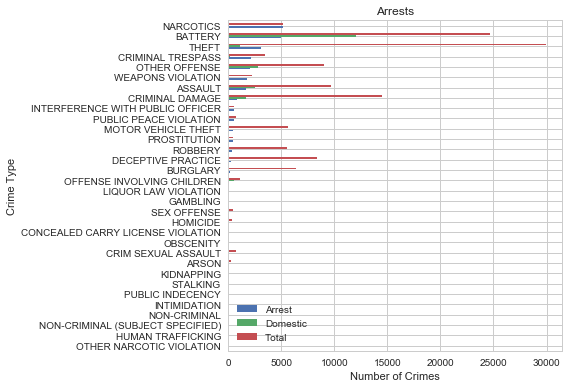

In [13]:
# plot crimes by arrests ascending
crime_type_counts.sort_values(by='Arrest', ascending=True).plot(kind='barh')
plt.title('Arrests')
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.tight_layout()
plt.show()

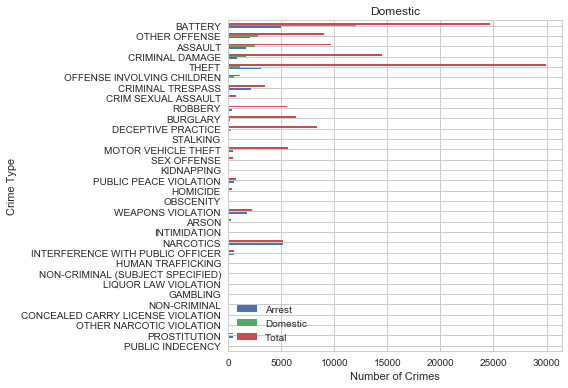

In [14]:
# plot crimes by domestic incident reports ascending
crime_type_counts.sort_values(by='Domestic', ascending=True).plot(kind='barh')
plt.title('Domestic')
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.tight_layout()
plt.show()

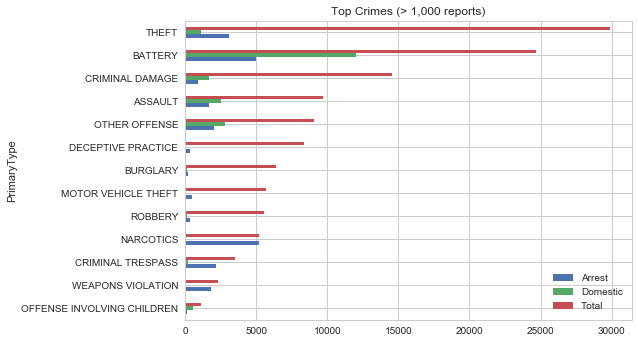

In [15]:
# top crimes
crime_type_counts[crime_type_counts['Total'] >= 1000].sort_values(by='Total', ascending=True)\
.plot(kind='barh')
plt.title('Top Crimes (> 1,000 reports)')

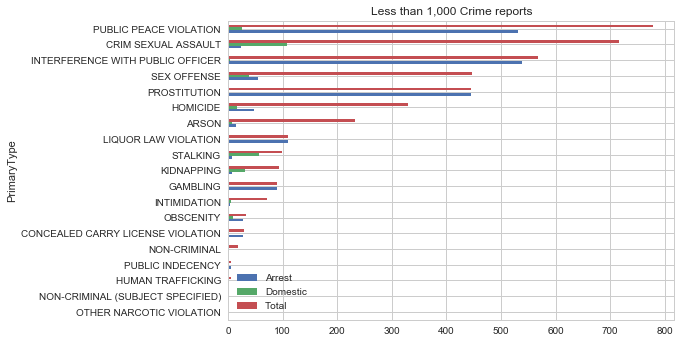

In [16]:
# less than 1000 crime reports
crime_type_counts[crime_type_counts['Total'] < 1000].sort_values(by='Total', ascending=True)\
.plot(kind='barh')
plt.title('Less than 1,000 Crime reports')

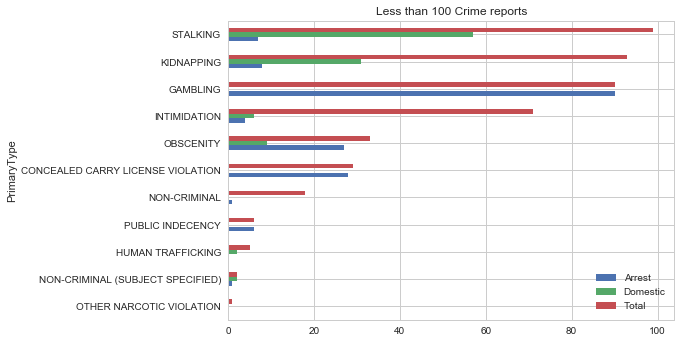

In [17]:
# less than 100 crime reports
crime_type_counts[crime_type_counts['Total'] < 100].sort_values(by='Total', ascending=True)\
.plot(kind='barh')
plt.title('Less than 100 Crime reports')

In [18]:
# get crime location counts
crime_locations = crimes.groupby('LocationDescription').size().compute()
crime_locations = crime_locations.sort_values(ascending=False).rename('Total') #.reset_index()
crime_locations.head()

LocationDescription
STREET       29382
RESIDENCE    22394
APARTMENT    16640
SIDEWALK      9959
OTHER         5350
Name: Total, dtype: int64

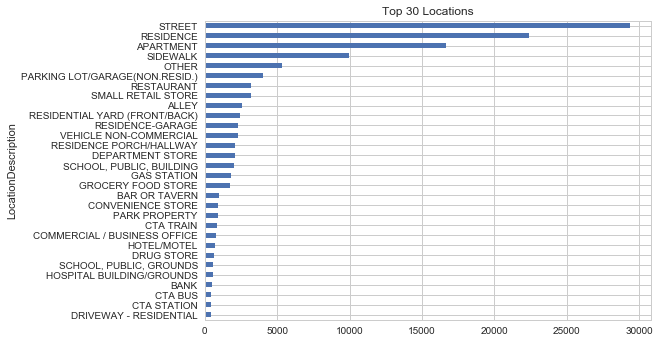

In [19]:
# plot top 30 locations
crime_locations[:30].sort_values(ascending=True).plot(kind='barh')
plt.title('Top 30 Locations')

In [20]:
# get arrests and domestic counts for each location description
crime_location_counts = crimes[['LocationDescription', 'Arrest', 'Domestic']]\
.groupby('LocationDescription').sum().compute()
# add crime location totals column
crime_location_counts['Total'] = crime_locations
crime_location_counts.head()

,Arrest,Domestic,Total
LocationDescription,,,
ABANDONED BUILDING,69.0,6.0,166
AIRCRAFT,2.0,0.0,31
AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA,5.0,1.0,47
AIRPORT BUILDING NON-TERMINAL - SECURE AREA,4.0,1.0,38
AIRPORT EXTERIOR - NON-SECURE AREA,6.0,1.0,43


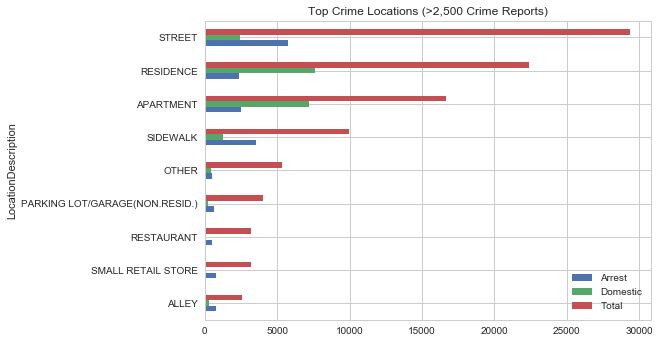

In [21]:
# plot top crime locations
crime_location_counts[crime_location_counts['Total'] >= 2500]\
.sort_values(by='Total', ascending=True).plot(kind='barh')
plt.title('Top Crime Locations (>2,500 Crime Reports)')

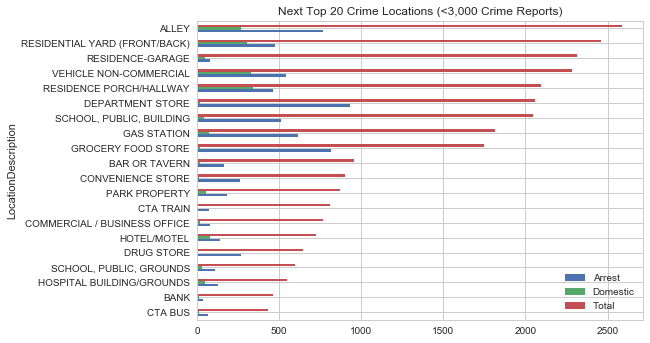

In [22]:
# plot next 20 top crime locations
crime_location_counts = crime_location_counts[crime_location_counts['Total'] <= 3000]\
.sort_values(by='Total', ascending=False)
crime_location_counts[:20].sort_values(by='Total', ascending=True).plot(kind='barh')
plt.title('Next Top 20 Crime Locations (<3,000 Crime Reports)')

In [23]:
crimes.index

Dask Index Structure:
npartitions=1
2017-01-01 00:00:00    datetime64[ns]
2017-07-04 23:50:00               ...
Name: Date, dtype: datetime64[ns]
Dask Name: read-parquet, 2 tasks

In [24]:
# get arrests
arrests = crimes[crimes['Arrest'] == True]['Arrest']
arrests.head()

Date
2017-05-31 19:13:00    True
2017-07-02 11:30:00    True
2017-07-04 23:04:00    True
2017-07-04 21:29:00    True
2017-07-04 23:42:00    True
Name: Arrest, dtype: bool

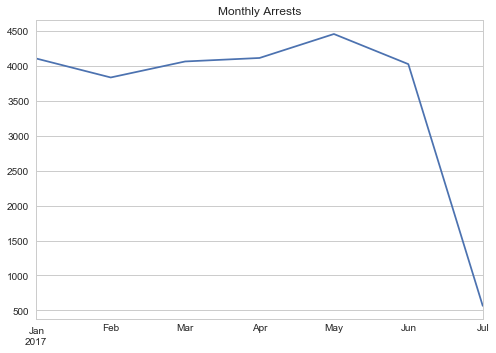

In [25]:
# plot monthly arrests
monthly_arrests = arrests.resample('M').sum().compute()
monthly_arrests.plot()
plt.title('Monthly Arrests')
plt.show()

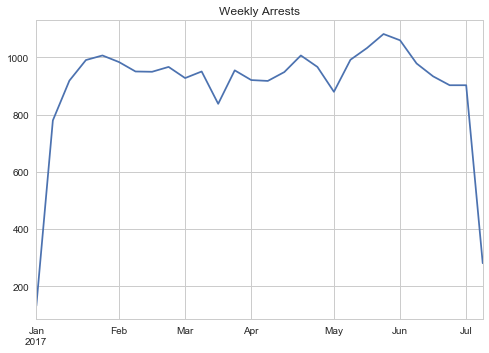

In [26]:
# plot weekly arrests
weekly_arrests = arrests.resample('W').sum().compute()
weekly_arrests.plot()
plt.title('Weekly Arrests')
plt.show()

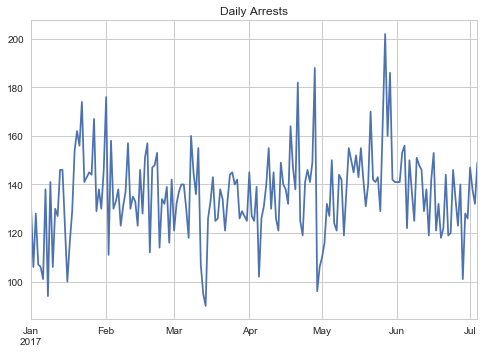

In [27]:
# plot daily arrests
daily_arrests = arrests.resample('D').sum().compute()
daily_arrests.plot()
plt.title('Daily Arrests')
plt.show()

In [28]:
# get domestic crimes
domestic = crimes[crimes['Domestic'] == True]['Domestic']
domestic.head()

Date
2017-07-04 18:00:00    True
2017-06-29 02:00:00    True
2017-07-02 14:00:00    True
2017-06-21 03:00:00    True
2017-05-01 08:00:00    True
Name: Domestic, dtype: bool

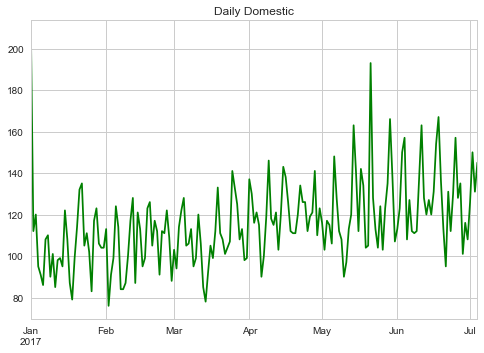

In [29]:
# plot daily domestic
daily_domestic = domestic.resample('D').sum().compute()
daily_domestic.plot(color='g')
plt.title('Daily Domestic')
plt.show()

In [30]:
# get daily crime counts
daily_crime = crime_types.resample('D').count().compute()
daily_crime.head()

,PrimaryType
2017-01-01,905
2017-01-02,597
2017-01-03,702
2017-01-04,607
2017-01-05,596


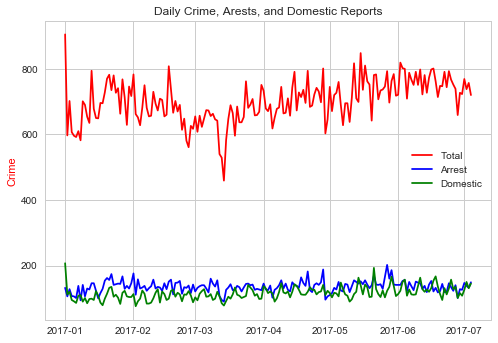

In [31]:
# plot daily crime counts, arrests, and domestic reports
fig, ax = plt.subplots()
ax.plot(daily_crime.index, daily_crime, label='Total', color='r', zorder=10)
ax.plot(daily_arrests.index, daily_arrests, color='b', zorder=10)
ax.plot(daily_domestic.index, daily_domestic, color='g', zorder=10)
ax.set_ylabel('Crime', color='r')
ax.legend(loc='right')
plt.title('Daily Crime, Arests, and Domestic Reports')
plt.show()